In [1]:
import numpy as np
from utils import read_dataset
import matplotlib.pyplot as plt 

In [2]:
dataset = read_dataset("Finn",
                       timestamp="10-12-24--17-14-13",
                       read_ort=True)

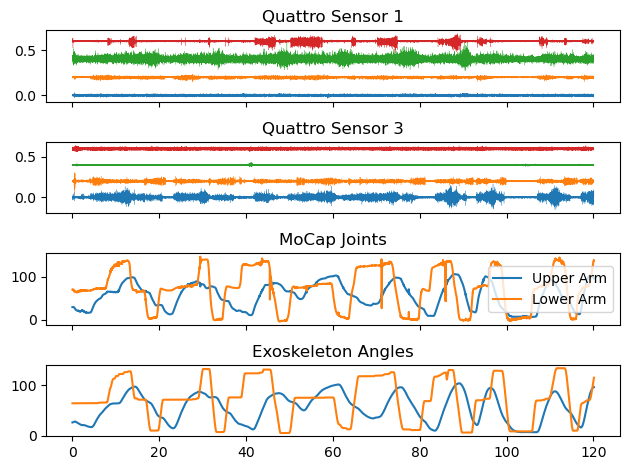

In [3]:
dataset[0].plot(plot_emg=True, plot_mocap_joints=True, plot_ort_angles=True)

In [4]:
dataset[0].mocap_joints.shape, dataset[0].upper_motor_angle.shape, dataset[0].lower_motor_angle.shape

((12010, 2), (5333, 1), (4952, 1))

In [5]:
# resample upper and lower motor angle to match mocap sample rate
x_lower = np.linspace(0, dataset[0].lower_motor_angle.shape[0], dataset[0].mocap_joints.shape[0])

lower_angle = np.interp(x_lower, np.arange(dataset[0].lower_motor_angle.shape[0]), dataset[0].lower_motor_angle[:, 0])

In [6]:
x_upper = np.linspace(0, dataset[0].upper_motor_angle.shape[0], dataset[0].mocap_joints.shape[0])

upper_angle = np.interp(x_upper, np.arange(dataset[0].upper_motor_angle.shape[0]), dataset[0].upper_motor_angle[:, 0])

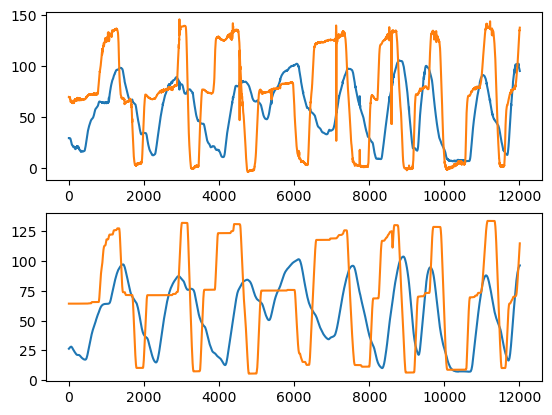

In [7]:
fig, axs = plt.subplots(2)
axs[0].plot(dataset[0].mocap_joints)
axs[1].plot(upper_angle)
axs[1].plot(lower_angle)

In [8]:
# shift measured exoskeleton angles backwards in time and calculcate min rmse 

max_ = 100
mocap = dataset[0].mocap_joints[:-max_, :]
exo_angles = np.vstack((upper_angle, lower_angle)).T
rmses = []
min_idx = 0
min_rmse = float("inf")
for i in range(max_): 
    rmse = np.sum(np.sqrt((mocap - exo_angles[i:-(max_ - i):])**2))
    if rmse < min_rmse: 
        min_rmse = rmse
        min_idx = i
    rmses.append(rmse)

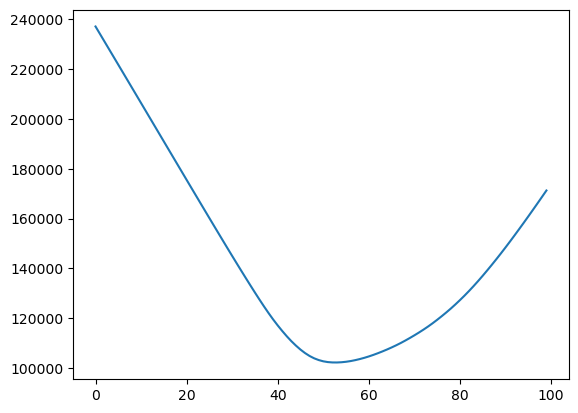

In [9]:
# rmse min is at ~ 50ms 
plt.plot(rmses)

In [10]:
min_idx, min_rmse

(53, 102236.25224153123)

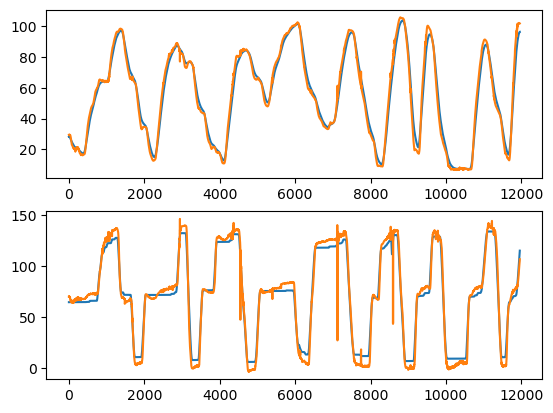

In [11]:
# apply best shift and plot mocap angles and exoskeleton angles in one plot to see min latency
fig, axs = plt.subplots(2)
axs[0].plot(exo_angles[min_idx:, 0])
axs[0].plot(dataset[0].mocap_joints[:-min_idx, 0])
axs[1].plot(exo_angles[min_idx:, 1])
axs[1].plot(dataset[0].mocap_joints[:-min_idx, 1])